In [448]:
library(tidyverse)
library(stringr) 
library(plotly)

In [449]:
##############################################################################

##########################     INPUT PARAMETERS    ###########################

##############################################################################



# filetype = # "ratio_cs1e9" # "ratio_singletons_excluded_tumor_cs" # "ratio_singletons_excluded_tumor_4_cs" # "ratio" 
filetype = "ratio_all_germline_singletons_excluded_tumor_4_cs"

# input_folder = "" # "filtered_bams_tumor_ci4_cs1e9" # "all_germline_filtered_bams_tumor_ci5_cs1e9", #ci5_cs1e9
input_folder = "all_germline_ci5_cs1e9"

# output_folder = # "ci1_cs1e9" # "ci2_cs1e9" # "ci5_cs1e9" # "filtered_tumor_bams_20_ci4_cs1e9"
output_folder = "union_germline_ci4_cs1e9"


In [450]:
paramspace = read.csv("../data/metadata/paramspace_cfDNA_phaseI.csv")

paramspace  <- paramspace %>% rename(patient_id = pt_id)
head(paramspace)

patient_id,cfDNA_folder,cfDNA_file,cfDNA_bam_path,unique_kmers_folder
C04689,C303A04689D_cfdna_N295-103,C303A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C303A04689D_cfdna_N295-103/C303A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450
C04689,C305A04689D_cfdna_N295-71,C305A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C305A04689D_cfdna_N295-71/C305A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450
C04689,C309A04689D_cfdna_N295-47,C309A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C309A04689D_cfdna_N295-47/C309A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450
C04689,C302A04689D_cfdna_N295-102,C302A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C302A04689D_cfdna_N295-102/C302A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450
C04689,C299A04689D_cfdna_N295-99,C299A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C299A04689D_cfdna_N295-99/C299A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450
C04689,C307A04689D_cfdna_N295-110,C307A04689D_cfdna.aligned.sorted.markdup.bam,../../DerivedData/main_data/C04689/C307A04689D_cfdna_N295-110/C307A04689D_cfdna.aligned.sorted.markdup.bam,C123T04689D_frfr_N295-450


In [451]:
SAMPLES = paramspace["patient_id"]
FOLDERS = paramspace["cfDNA_folder"]

In [452]:
paramspace["big_ratio"] <- NA
paramspace["big_ratio_CI_lower"] <- NA
paramspace["big_ratio_CI_upper"] <- NA

paramspace["small_ratio"] <- NA
paramspace["small_ratio_CI_lower"] <- NA
paramspace["small_ratio_CI_upper"] <- NA

for (row in 1:nrow(paramspace)){
    pt = paramspace[row, "patient_id"]
    #print(pt)
    fd = paramspace[row, "cfDNA_folder"]
    big_r = read.csv(paste("../data/", pt, "/" , fd, "/", input_folder, "/", "big_", filetype, ".csv", sep = ""))
    small_r = read.csv(paste("../data/", pt, "/", fd, "/", input_folder, "/", "small_", filetype, ".csv", sep = ""))
    #print(big_r[[1]])
    #print(small_r[[1]])
    paramspace[row, "big_ratio"] = big_r$ratio
    paramspace[row, "big_ratio_CI_lower"] = big_r$lower_CI
    paramspace[row, "big_ratio_CI_upper"] = big_r$upper_CI
    
    paramspace[row, "small_ratio"] = small_r$ratio
    paramspace[row, "small_ratio_CI_lower"] = small_r$lower_CI
    paramspace[row, "small_ratio_CI_upper"] = small_r$upper_CI
}

In [453]:
res <- paramspace

In [454]:
#res <- res %>% separate(cfDNA_folder, c("sampleID", "sample_type", "sample_number"))
res <- res %>% 
  mutate(tmp_chunks = stringr::str_split(cfDNA_folder, stringr::fixed("_"),  n = 3)) %>%
  mutate(sampleID = map_chr(tmp_chunks, 1),
         sub_value = map_chr(tmp_chunks, 2), 
         sub_val = map_chr(tmp_chunks, 3)) %>%
  select(-c(tmp_chunks, sub_value, sub_val))


In [455]:
sample_timepoint <- read.csv("../data/metadata/clin_data/sample_timepoint_formatted.csv")

In [456]:
head(sample_timepoint)
sample_timepoint_days <- sample_timepoint %>% filter(phase == "phaseI")
sample_timepoint_days <- sample_timepoint_days %>% select(sampleID, sample_timepoint_days_since_OP)
sample_timepoint_days %>% filter(is.na(sample_timepoint_days_since_OP))

biobankID,sample_timepoint_days_since_OP,phase,patient_id,sampleID
1982,-6,phaseII,C01982,C84A01982D
1982,15,phaseII,C01982,C85A01982D
1982,142,phaseII,C01982,C86A01982D
1982,241,phaseII,C01982,C87A01982D
3736,-1,phaseII,C03736,C211A03736D
3736,43,phaseII,C03736,C212A03736D


sampleID,sample_timepoint_days_since_OP


In [457]:
res$sampleID <- as.character(res$sampleID)
res <- left_join(res, sample_timepoint_days, by = c("sampleID"))

In [458]:
clinical_data <- read.csv("../data/metadata/clin_data/clinical_data_formatted.csv")
clinical_data_relapse <- clinical_data %>% select(patient_id, time_to_relapse_days, adjuvant_chemo_start_days, adjuvant_chemo_end_days)

In [459]:
res <-left_join(res, clinical_data_relapse, by="patient_id")

In [460]:
res <- res %>% select(patient_id, cfDNA_folder, sampleID, sample_timepoint_days_since_OP, time_to_relapse_days, big_ratio, small_ratio)

In [461]:
res_new <-  data.frame(matrix(ncol = ncol(res), nrow = 0))
colnames(res_new) <- c(colnames(res))

In [462]:
res_new

patient_id,cfDNA_folder,sampleID,sample_timepoint_days_since_OP,time_to_relapse_days,big_ratio,small_ratio


In [463]:
patients <- as.character(unique(res$patient_id))

In [464]:
for (i in patients){
    patient <- res %>% filter(patient_id == i)
    #print(patient)
    if(is.na(sum(patient$time_to_relapse_days))){new_row = patient %>% filter(sample_timepoint_days_since_OP == max(sample_timepoint_days_since_OP))}else{
        relapse_timepoint = min(patient$time_to_relapse_days, na.rm=TRUE)
        before_relapse = patient %>% filter(sample_timepoint_days_since_OP <time_to_relapse_days)
        #print(before_relapse)
        new_row = before_relapse %>% filter(sample_timepoint_days_since_OP == max(sample_timepoint_days_since_OP))}
    res_new[nrow(res_new)+1,] = c(i, j, new_row[3:7])}

In [465]:
res_new

patient_id,cfDNA_folder,sampleID,sample_timepoint_days_since_OP,time_to_relapse_days,big_ratio,small_ratio
C04689,C243A05703D_cfdna_N295-171,C312A04689D,1085,NA,0.0394954432,0.036111135
C04816,C243A05703D_cfdna_N295-171,C283A04816D,1084,NA,0.0076535187,0.036373827
C04837,C243A05703D_cfdna_N295-171,C248A04837D,1104,NA,0.0903676306,0.117981695
C04849,C243A05703D_cfdna_N295-171,C256A04849D,323,362.2063,0.8279563420,0.854014279
C04873,C243A05703D_cfdna_N295-171,C211A04873D,1092,NA,0.0164356735,0.055832882
C04874,C243A05703D_cfdna_N295-171,C189A04874D,366,395.6875,0.0246409010,0.028398877
C04886,C243A05703D_cfdna_N295-171,C274A04886D,1068,NA,0.0136837605,0.046759051
C04887,C243A05703D_cfdna_N295-171,C243A04887D,1082,NA,0.1235632392,0.136373862
C05048,C243A05703D_cfdna_N295-171,C284A05048D,1057,NA,0.0006732299,0.001318159
C05073,C243A05703D_cfdna_N295-171,C234A05073D,1079,NA,0.0391492118,0.052618977


In [466]:
res_new <- res_new %>% mutate(sample_label = "last_before_relapse")

In [467]:
res_new <- res_new %>% select(patient_id, cfDNA_folder, sampleID, big_ratio, small_ratio, sample_timepoint_days_since_OP, sample_label)

In [468]:
res_new

patient_id,cfDNA_folder,sampleID,big_ratio,small_ratio,sample_timepoint_days_since_OP,sample_label
C04689,C243A05703D_cfdna_N295-171,C312A04689D,0.0394954432,0.036111135,1085,last_before_relapse
C04816,C243A05703D_cfdna_N295-171,C283A04816D,0.0076535187,0.036373827,1084,last_before_relapse
C04837,C243A05703D_cfdna_N295-171,C248A04837D,0.0903676306,0.117981695,1104,last_before_relapse
C04849,C243A05703D_cfdna_N295-171,C256A04849D,0.8279563420,0.854014279,323,last_before_relapse
C04873,C243A05703D_cfdna_N295-171,C211A04873D,0.0164356735,0.055832882,1092,last_before_relapse
C04874,C243A05703D_cfdna_N295-171,C189A04874D,0.0246409010,0.028398877,366,last_before_relapse
C04886,C243A05703D_cfdna_N295-171,C274A04886D,0.0136837605,0.046759051,1068,last_before_relapse
C04887,C243A05703D_cfdna_N295-171,C243A04887D,0.1235632392,0.136373862,1082,last_before_relapse
C05048,C243A05703D_cfdna_N295-171,C284A05048D,0.0006732299,0.001318159,1057,last_before_relapse
C05073,C243A05703D_cfdna_N295-171,C234A05073D,0.0391492118,0.052618977,1079,last_before_relapse


In [469]:
phase_I_pts = c('C04689', 'C04816', 'C04837', 'C04849', 'C04873', 'C04874', 'C04886', 'C04887', 'C05048', 'C05073', 'C05084', 'C05118', 'C05194', 'C05234', 'C05703')

res_min <- NULL
for (pt in phase_I_pts){
    res_pt <- res %>% filter(patient_id == pt)
    res_pt$sample_timepoint_days_since_OP <- as.numeric(res_pt$sample_timepoint_days_since_OP)
    
    # order based on sample timepoint
    res_pt <- res_pt %>% arrange(sample_timepoint_days_since_OP)
    head(res_pt)
    
    # pick first 2
    res_pt <- res_pt[1:2, ]
    print(dim(res_pt))
    
    res_pt <- res_pt %>% mutate(sample_label = c("pre-op", "post-op"))
    
    # save to res min
    res_min <- rbind(res_min, res_pt)
    
    }

res_min <- res_min %>% select(patient_id, cfDNA_folder, sampleID, big_ratio, small_ratio, sample_timepoint_days_since_OP, sample_label)

[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7
[1] 2 7


In [470]:
res_three_points <- bind_rows(res_min, res_new)

In [471]:
res_three_points

patient_id,cfDNA_folder,sampleID,big_ratio,small_ratio,sample_timepoint_days_since_OP,sample_label
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.0406719006,0.039369310,-1,pre-op
C04689,C300A04689D_cfdna_N295-100,C300A04689D,0.0399567058,0.036728496,37,post-op
C04816,C270A04816D_cfdna_N295-104,C270A04816D,0.0087251942,0.044098940,-6,pre-op
C04816,C271A04816D_cfdna_N295-105,C271A04816D,0.0089777230,0.049513012,27,post-op
C04837,C237A04837D_cfdna_N295-61,C237A04837D,0.0909416609,0.116678085,-1,pre-op
C04837,C238A04837D_cfdna_N295-63,C238A04837D,0.0871220114,0.104701623,47,post-op
C04849,C252A04849D_cfdna_N295-64,C252A04849D,0.8210453525,0.856566000,0,pre-op
C04849,C253A04849D_cfdna_N295-62,C253A04849D,0.8202109803,0.855206445,42,post-op
C04873,C75A04873D_cfdna_N295-219,C75A04873D,0.0175731679,0.046805889,-1,pre-op
C04873,C206A04873D_cfdna_N295-74,C206A04873D,0.0090496643,0.032945117,83,post-op


In [472]:
normalized_res <- data.frame(matrix(ncol = ncol(res_three_points)+2, nrow = 0))
colnames(normalized_res) <- c(colnames(res_three_points), "big_ratio_normalized", "small_ratio_normalized")

In [473]:
patients = as.character(unique(res_three_points$patient_id))

In [474]:
for (i in patients){
    res_pt <- res_three_points %>% filter(patient_id == i)
    
    for (x in res_pt$cfDNA_folder){
        sample_label_check <- res_pt %>% filter(cfDNA_folder == x)
        
        if (sample_label_check$sample_label == "pre-op"){
            pre_val_big = sample_label_check$big_ratio
            pre_val_small = sample_label_check$small_ratio}}
    
    for (j in res_pt$cfDNA_folder){
        normalized_line <- res_pt %>% filter(cfDNA_folder == j)
        #print(normalized_line)
        normalized_line <- normalized_line %>% mutate(big_ratio_normalized = big_ratio/pre_val_big, small_ratio_normalized = small_ratio/pre_val_small)
        #print(normalized_line)
        normalized_res[nrow(normalized_res)+1,] = c(i, j, normalized_line[3:9])
    
    }}

In [475]:
normalized_res <- normalized_res %>% mutate(pre_post_time = ifelse(sample_label == "pre-op", 0, sample_timepoint_days_since_OP))

In [476]:
Correlations <- read.csv("../data/ci5_cs1e9_correlation.csv")
relapse_label <- Correlations %>% select(pt_id, Relapse)
colnames(relapse_label) <- c("patient_id", "Relapse_label")
normalized_res <- left_join(normalized_res, relapse_label, by="patient_id")

In [477]:
normalized_res

patient_id,cfDNA_folder,sampleID,big_ratio,small_ratio,sample_timepoint_days_since_OP,sample_label,big_ratio_normalized,small_ratio_normalized,pre_post_time,Relapse_label
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse
C04689,C299A04689D_cfdna_N295-99,C299A04689D,0.04067190,0.03936931,-1,pre-op,1.0000000,1.0000000,0,No_relapse


In [478]:
normalized_res_without_post_op <- normalized_res %>% filter(sample_label != "post-op")

In [479]:
quick_plot_big_r_normalized <- ggplot(normalized_res_without_post_op) + geom_line(aes(x = pre_post_time, y = log10(big_ratio_normalized), color = Relapse_label, group=patient_id)) + 
                                      geom_point(aes(x = pre_post_time, y = log10(big_ratio_normalized), color = Relapse_label)) + theme(text = element_text(size = 20)) 
ggsave(
  paste("../plotting_results/", output_folder, "/PhaseI_samples_pre_post_relapse_plot_normalized_big_", filetype, ".png", sep = ""),
  quick_plot_big_r_normalized, dpi = "print")

Saving 6.67 x 6.67 in image


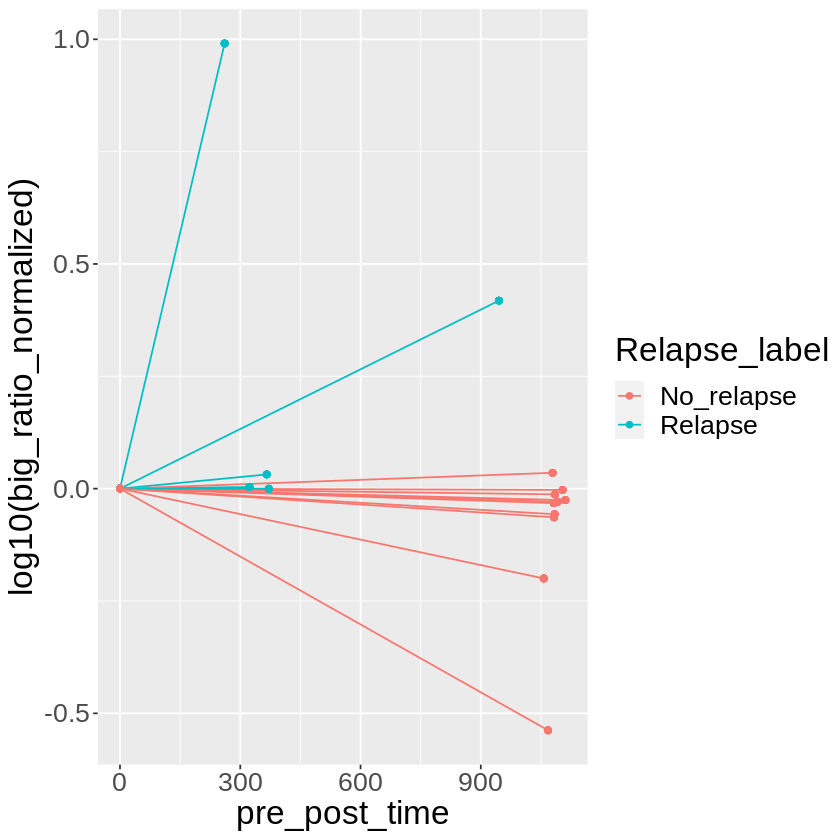

In [480]:
quick_plot_big_r_normalized

In [481]:
quick_plot_small_r_normalized <- ggplot(normalized_res_without_post_op) + geom_line(aes(x = pre_post_time, y = log10(small_ratio_normalized), color = Relapse_label, group=patient_id)) + 
                                      geom_point(aes(x = pre_post_time, y = log10(small_ratio_normalized), color = Relapse_label)) + theme(text = element_text(size = 20)) 
ggsave(
  paste("../plotting_results/", output_folder, "/PhaseI_samples_pre_post_relapse_plot_normalized_small_", filetype, ".png", sep = ""),
  quick_plot_small_r_normalized, dpi = "print")

Saving 6.67 x 6.67 in image


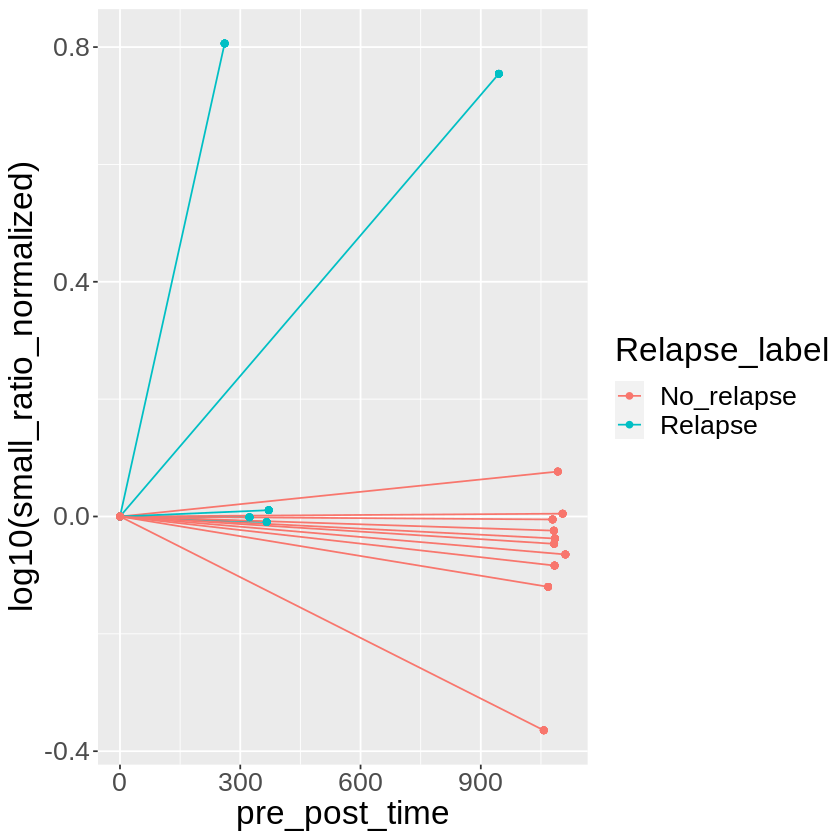

In [482]:
quick_plot_small_r_normalized